In [ ]:
import torch
from torch import pi

**Heat equation:**

$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$

- Boundary Conditions (for all $t \geq 0$.): 
    - $u(0, t) = 0$
    - $u(1, t) = 0$
- Initial Condition:
    - $u(x, 0) = \sin(\pi x)$ for $0 \leq x \leq 1$.

**Analytical solution:**

$u(x,t) = e^{-\alpha \pi^2 t} \sin(\pi x)$

In [ ]:
def u(x, t, alpha):
    return torch.exp(-alpha*(pi**2)*t)*torch.sin(pi*x)

def du_dt(x, t, alpha):
    return -(alpha*pi**2)*torch.exp(-alpha*t*pi**2)*torch.sin(pi*x)

def d2u_dx2(x, t, alpha):
    return -(pi**2)*torch.exp(-alpha*t*pi**2)*torch.sin(pi*x)

In [ ]:
n_x = 100
n_t = 100
max_t = 100
alpha = 4*1e-8

features, t = torch.linspace(start=0, end=1, steps=n_x), torch.linspace(start=0, end=max_t, steps=n_t)
xx, tt = torch.meshgrid(features, t)
y = u(xx, tt, alpha)

dataset = torch.utils.data.TensorDataset(
    # torch.vstack((xx.flatten(),tt.flatten())).T.requires_grad_(),
    xx.flatten().requires_grad_(),
    tt.flatten().requires_grad_(),
    y.flatten().unsqueeze(1)
    )

c:\Users\andre\miniconda3\envs\hc-mkl\Lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 48),
    torch.nn.GELU(),
    torch.nn.Linear(48, 48),
    torch.nn.Sigmoid(),
    torch.nn.Linear(48, 32),
    torch.nn.GELU(),
    torch.nn.Linear(32,1)
)

In [ ]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.005)
loader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)

In [ ]:
constraints = [
    lambda _, t: model(torch.vstack((torch.zeros_like(t), t)).T),
    lambda _, t: model(torch.vstack((torch.ones_like(t), t)).T),
    lambda x, _: model(torch.vstack((x, torch.zeros_like(x))).T) - torch.sin(torch.pi*x)
]

In [ ]:
# for x, t, y in loader:
import numpy as np


epochs = 200
mse_loss = torch.nn.MSELoss()
epoch_loss_log = []
epoch_c_log = []
for epoch in range(epochs):
    loss_log = []
    c_log = []
    for x, t, y in loader:
    # for features, y in loader:
        y_hat = model(
            torch.vstack((x, t)).T
        )
        cs = []
        with torch.no_grad():
            for j, constraint in enumerate(constraints):
                c = torch.mean(constraint(x, t)) #+ slack_vars[j]
                cs.append(c.detach().numpy())
            
            c_log.append(np.array(cs))
        
        # y_hat = model(features)
        # y_hat = u(x=features[:,0], t=features[:,1], alpha=alpha)

        jac_x = torch.autograd.grad(
            outputs=y_hat.unbind(),
            inputs=x,
            grad_outputs=None,
            create_graph=True,
            materialize_grads=True)[0]
        
        jac_t = torch.autograd.grad(
            outputs=y_hat.unbind(),
            inputs=t,
            grad_outputs=None,
            create_graph=True,
            materialize_grads=True)[0]
        
        hess_x = torch.autograd.grad(
            outputs=jac_x.unbind(),
            inputs=x,
            create_graph=True,
            materialize_grads=True)[0]
        
        # jac_t = jac[:,1]

        loss_d = mse_loss(jac_t, alpha*hess_x)
        loss_pred = mse_loss(y_hat, y)

        loss = loss_d + loss_pred
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_log.append(loss.detach().numpy())
    print(sum(loss_log)/len(loss_log))
    epoch_loss_log.append(sum(loss_log)/len(loss_log))
    print(sum(c_log)/len(c_log))
    epoch_c_log.append(sum(c_log)/len(c_log))

0.30264285
[ 0.19202825  0.18968254 -0.6632907 ]
0.17114338
[ 0.38140613  0.37826926 -0.5625278 ]
0.13028237
[ 0.4904101   0.48698243 -0.5034995 ]
0.11805527
[ 0.55045974  0.5468966  -0.4693257 ]
0.11429702
[ 0.5819982   0.5783792  -0.44769764]
0.11260557
[ 0.5980287   0.5943979  -0.43441853]
0.11179682
[ 0.6062336   0.60259885 -0.42479786]
0.111235715
[ 0.61013496  0.6065022  -0.41700396]
0.110413626
[ 0.6120361  0.6084059 -0.4100604]
0.109924495
[ 0.6146792  0.6110478 -0.4031288]
0.1094118
[ 0.6145842   0.61095184 -0.39797777]
0.10877861
[ 0.61510795  0.6114714  -0.39299494]
0.10835848
[ 0.61620265  0.6125599  -0.38750917]
0.10795671
[ 0.6171818   0.61355126 -0.38209113]
0.10783015
[ 0.618914    0.61528444 -0.37594897]
0.107228324
[ 0.6187557  0.6151483 -0.3719128]
0.10702387
[ 0.61850506  0.6149322  -0.36762977]
0.10660382
[ 0.6189542   0.61540514 -0.3632844 ]
0.106316246
[ 0.6201705   0.6166474  -0.35850412]
0.10599221
[ 0.6192692  0.615785  -0.3554313]
0.105856754
[ 0.6203898   0.

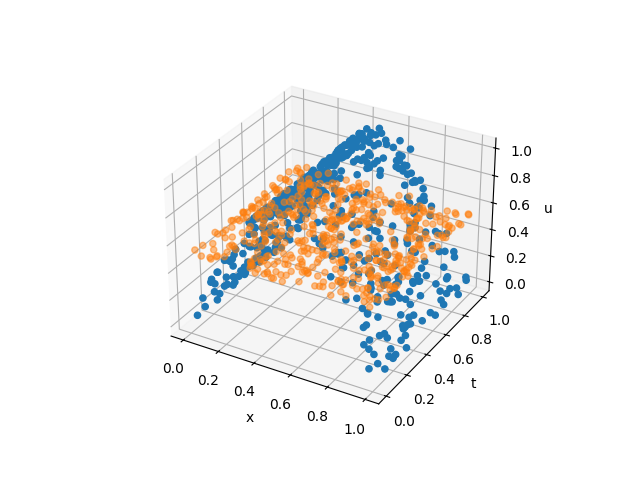

In [ ]:
%matplotlib ipympl


from matplotlib import pyplot as plt

# idx = torch.randperm(100)

with torch.inference_mode():
    x = torch.rand(500)
    t = torch.rand(500)
    _u = u(x, t, alpha=alpha)
    preds = model(torch.vstack((x, t)).T).flatten()
    ax = plt.figure().add_subplot(projection='3d')
    ax.scatter(xs=x, ys=t, zs=_u, alpha=1)
    ax.scatter(xs=x, ys=t, zs=preds,alpha=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')

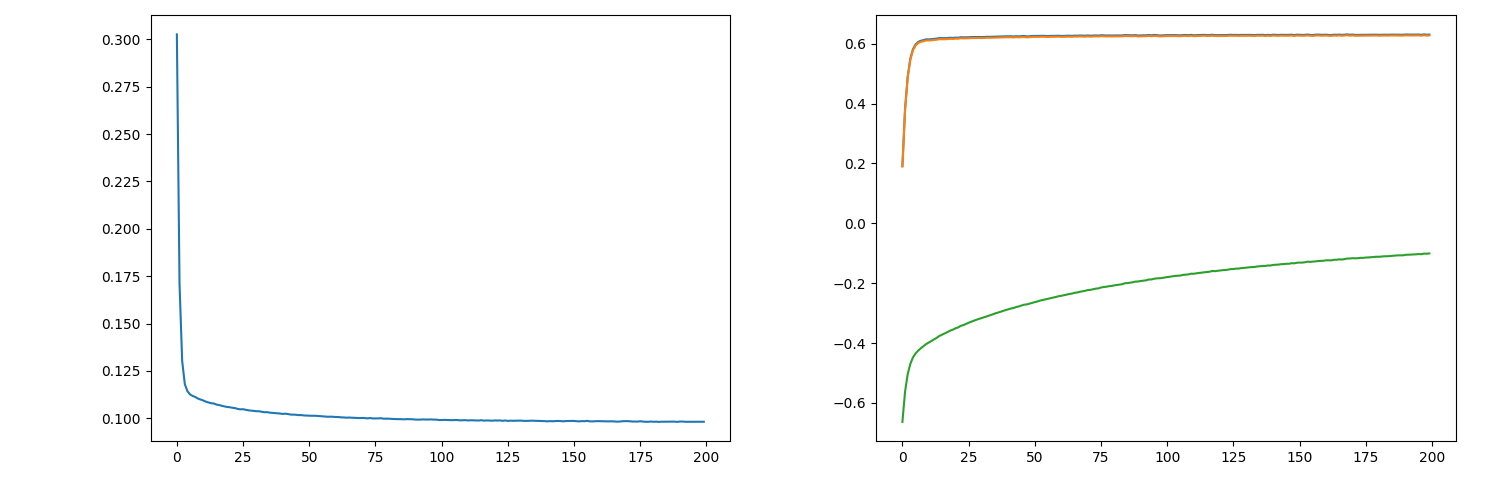

In [ ]:
f = plt.figure()
ax = f.subplots(1,2)
ax[0].plot(epoch_loss_log)
ax[1].plot(epoch_c_log)
f.tight_layout()
f.set_figwidth(15)

In [ ]:
loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

In [ ]:
from humancompatible.train.algorithms import SSLALM, SSLALM_Adam

model = torch.nn.Sequential(
    torch.nn.Linear(2, 48),
    torch.nn.GELU(),
    torch.nn.Linear(48, 48),
    torch.nn.Sigmoid(),
    torch.nn.Linear(48, 32),
    torch.nn.GELU(),
    # torch.nn.Linear(32, 16),
    # torch.nn.Tanh(),
    torch.nn.Linear(32,1)
)


constraints = [
    lambda _, t: torch.nn.functional.mse_loss(model(torch.vstack((torch.zeros_like(t), t)).T), torch.zeros_like(t).unsqueeze(1)),
    lambda _, t: torch.nn.functional.mse_loss(model(torch.vstack((torch.ones_like(t), t)).T), torch.zeros_like(t).unsqueeze(1)),
    # lambda x, _: model(torch.vstack((x, torch.zeros_like(x))).T) - torch.sin(torch.pi*x)
]
m = len(constraints)
slack_vars = torch.zeros(m).requires_grad_()

optimizer = SSLALM_Adam(
    params=model.parameters(),
    m=m,
    mu=0.,
    lr=0.005,
    # dual_lr=0.01,
    dual_lr=0.,
    rho=1.,
    dual_bound=10,
)

In [ ]:
import numpy as np


epochs = 30
mse_loss = torch.nn.MSELoss()

for epoch in range(epochs):
    loss_log = []
    c_log = []
    for x ,t, y in loader:
        y_hat = model(
            torch.vstack((x, t)).T
        )
        
        cs = []
        for j, constraint in enumerate(constraints):
            c = constraint(x, t)# + slack_vars[j]
            c.backward()
            optimizer.dual_step(j, c)
            optimizer.zero_grad()
            
            cs.append((c.detach()- slack_vars[j]).detach().numpy())
        c_log.append(np.array(cs))

        jac_x = torch.autograd.grad(
            outputs=y_hat.unbind(),
            inputs=x,
            grad_outputs=None,
            create_graph=True,
            materialize_grads=True)[0]
        
        jac_t = torch.autograd.grad(
            outputs=y_hat.unbind(),
            inputs=t,
            grad_outputs=None,
            create_graph=True,
            materialize_grads=True)[0]
        
        hess_x = torch.autograd.grad(
            outputs=jac_x.unbind(),
            inputs=x,
            create_graph=True,
            materialize_grads=True)[0]

        loss_d = mse_loss(jac_t, alpha*hess_x)
        loss_pred = mse_loss(y_hat, y)

        loss = loss_d + loss_pred #+ torch.zeros_like(slack_vars) @ slack_vars
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # optimizer.dual_lr *= 0.97

        with torch.no_grad():
            for j in range(len(slack_vars)):
                if slack_vars[j] < 0:
                    slack_vars[j].zero_()

        loss_log.append(loss.detach().numpy())
    print(sum(loss_log)/len(loss_log))
    print(sum(c_log)/len(c_log))

0.14385174
[0.19875172 0.1980449 ]
0.13052256
[0.20129374 0.2001905 ]
0.1309739
[0.2012937  0.19763318]
0.122942686
[0.20035169 0.18827698]
0.078236744
[0.11925544 0.13048491]
0.011076855
[0.01549194 0.02325013]
0.0016396794
[0.00237622 0.00692857]
0.00345967
[0.00346939 0.00752885]
0.0024000902
[0.00207373 0.00545232]
0.00024959195
[0.0002977  0.00209367]
0.00050659094
[0.00051597 0.00166923]
0.0006197833
[0.0005785 0.0015353]
0.0001909849
[0.00026432 0.00107823]
0.0010384223
[0.00092919 0.00170084]
0.0009350139
[0.0008277 0.0018531]
0.0021368251
[0.00167847 0.00362191]
0.00017387976
[0.00027723 0.00089377]
0.00013899479
[0.00028543 0.00081786]
0.00010140576
[0.00021899 0.00071049]
0.0013255246
[0.00129347 0.00211052]
0.00048110238
[0.00066036 0.00139135]
0.0024856036
[0.00221444 0.00493177]
0.00022857284
[0.00028486 0.00143116]
0.00044898945
[0.00044396 0.00117861]
0.0004862979
[0.00053795 0.00106971]
0.00027207346
[0.00037954 0.00086892]
0.0009849074
[0.00091954 0.0016379 ]
0.000517

In [ ]:
optimizer._dual_vars

tensor([0., 0.], grad_fn=<AddBackward0>)

Overall MSE
tensor(4.4041e-05)
MSE on x=0
tensor(1.6591e-05)
MSE on x=1
tensor(0.0009)


C:\Users\andre\AppData\Local\Temp\ipykernel_9140\4268747925.py:16: UserWarning: Using a target size (torch.Size([500])) that is different to the input size (torch.Size([500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print(torch.nn.functional.mse_loss(model(torch.vstack((torch.zeros_like(t), t)).T), torch.zeros_like(preds)))
C:\Users\andre\AppData\Local\Temp\ipykernel_9140\4268747925.py:18: UserWarning: Using a target size (torch.Size([500])) that is different to the input size (torch.Size([500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print(torch.nn.functional.mse_loss(model(torch.vstack((torch.ones_like(t), t)).T), torch.zeros_like(preds)))
C:\Users\andre\AppData\Local\Temp\ipykernel_9140\4268747925.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained un

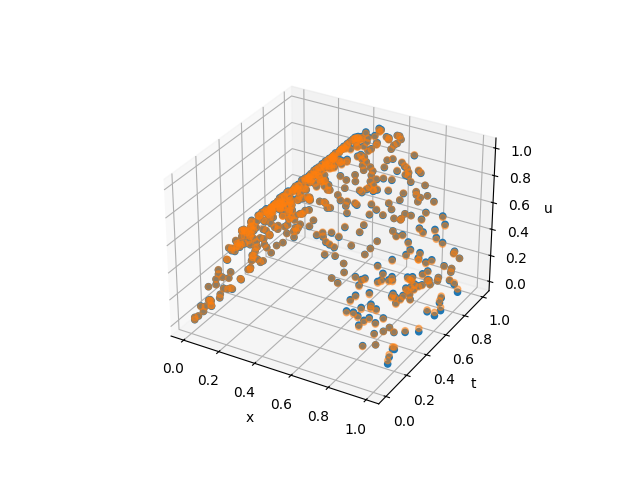

In [ ]:

%matplotlib ipympl


from matplotlib import pyplot as plt

# idx = torch.randperm(100)

with torch.inference_mode():
    x = torch.rand(500)
    t = torch.rand(500)
    _u = u(x, t, alpha=alpha)
    preds = model(torch.vstack((x, t)).T).flatten()
    print('Overall MSE')
    print(torch.nn.functional.mse_loss(preds, _u))
    print('MSE on x=0')
    print(torch.nn.functional.mse_loss(model(torch.vstack((torch.zeros_like(t), t)).T), torch.zeros_like(preds)))
    print('MSE on x=1')
    print(torch.nn.functional.mse_loss(model(torch.vstack((torch.ones_like(t), t)).T), torch.zeros_like(preds)))
    ax = plt.figure().add_subplot(projection='3d')
    ax.scatter(xs=x, ys=t, zs=_u, alpha=1)
    ax.scatter(xs=x, ys=t, zs=preds,alpha=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')